   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60 

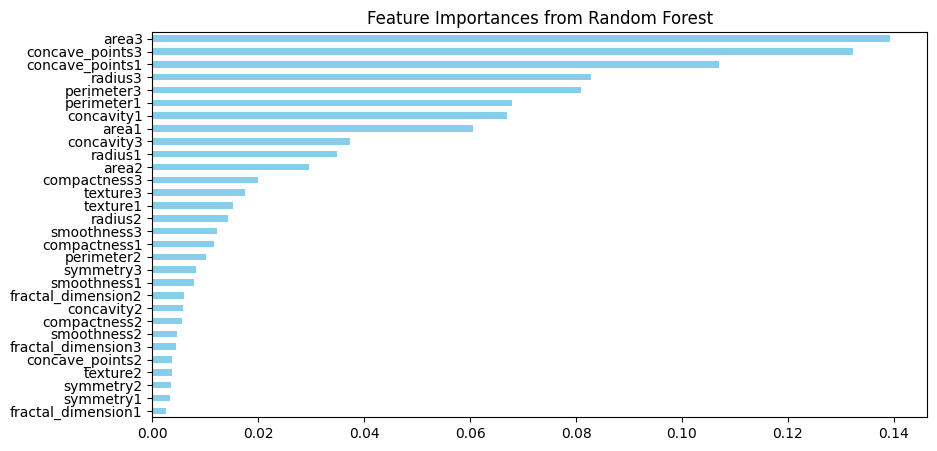

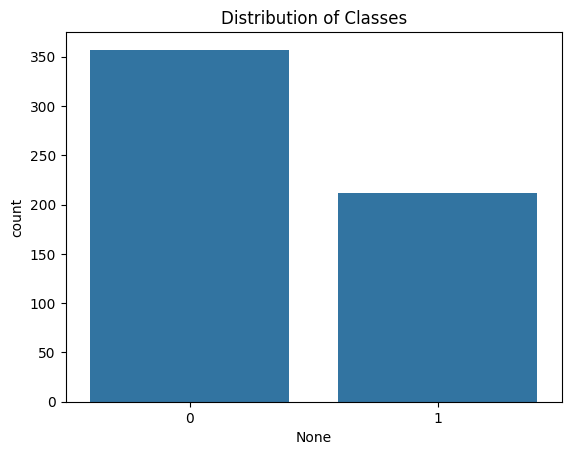

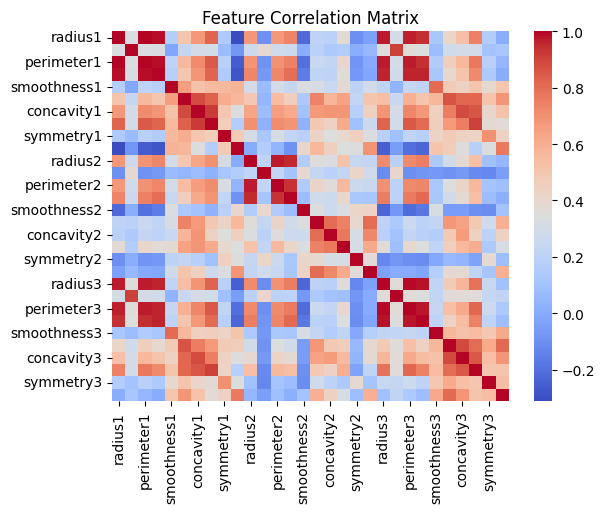

Logistic Regression Accuracy: 0.9582
Random Forest Accuracy: 0.9670
SVM Accuracy: 0.9626
k-NN Accuracy: 0.9604
Decision Tree Accuracy: 0.9319
Gradient Boosting Accuracy: 0.9582
XGBoost Accuracy: 0.9714
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
              precision    recall  f1-score     support
B              0.960000  1.000000  0.979592   72.000000
M              1.000000  0.928571  0.962963   42.000000
accuracy       0.973684  0.973684  0.973684    0.973684
macro avg      0.980000  0.964286  0.971277  114.000000
weighted avg   0.974737  0.973684  0.973465  114.000000


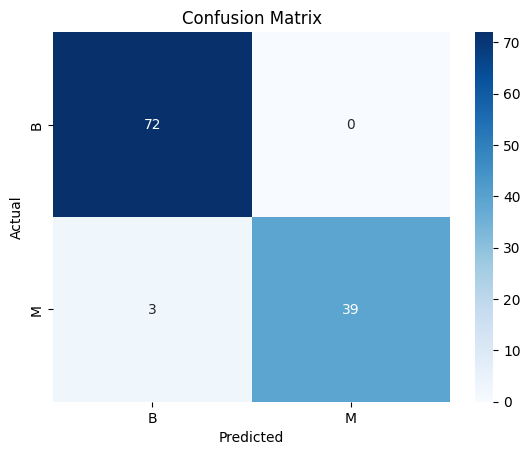

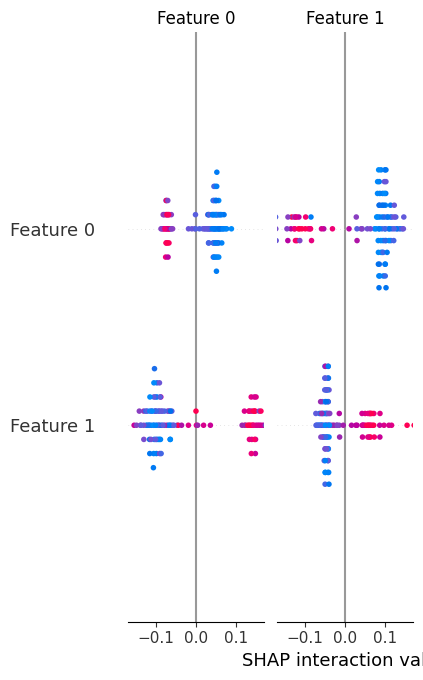

['breast_cancer_tuned_model.pkl']

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
import warnings
import joblib

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Suppress warnings
warnings.filterwarnings('ignore')

# Fetch dataset
breast_cancer = fetch_ucirepo(id=17)
X = breast_cancer.data.features
y = breast_cancer.data.targets.squeeze()  # Ensure y is 1D

# Encode labels dynamically
le = LabelEncoder()
y = le.fit_transform(y)
class_names = le.classes_.tolist()  # Dynamically get class names

# Data exploration
print(X.head(), y[:5])
print("Missing Values:", X.isnull().sum().sum())

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for feature selection
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Feature selection using RandomForest feature importance
selector = RandomForestClassifier(n_estimators=100, random_state=42)
selector.fit(X_scaled, y)
feature_importances = pd.Series(selector.feature_importances_, index=X.columns)
selected_features = feature_importances.nlargest(15).index
X_selected = X_scaled_df[selected_features].values  # Convert back to NumPy array

# Visualize Feature Importance
plt.figure(figsize=(10, 5))
feature_importances.sort_values().plot(kind='barh', color='skyblue')
plt.title("Feature Importances from Random Forest")
plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Class distribution
sns.countplot(x=pd.Series(y))
plt.title("Distribution of Classes")
plt.show()

# Correlation matrix
sns.heatmap(X_scaled_df.corr(), cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Model evaluation
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear'),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(objective='binary:logistic', eval_metric='logloss', verbosity=0)
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    print(f"{name} Accuracy: {np.mean(scores):.4f}")

# Hyperparameter tuning
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=5, n_iter=10, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)

# Train best model with best parameters
best_params = random_search.best_params_
best_tuned_model = RandomForestClassifier(**best_params, random_state=42)
best_tuned_model.fit(X_train, y_train)
y_pred = best_tuned_model.predict(X_test)

# Evaluation metrics
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SHAP Explainability
explainer = shap.Explainer(best_tuned_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# LIME Explainability
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train, feature_names=selected_features, class_names=class_names, mode='classification')
exp = explainer_lime.explain_instance(X_test[0], best_tuned_model.predict_proba)
exp.show_in_notebook()

# Save model
joblib.dump(best_tuned_model, "breast_cancer_tuned_model.pkl")